In [41]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import pandas as pd
from collections import OrderedDict
from context import BIP_LWR

from BIP_LWR.tools.vis import mcmc_vis_tools
from BIP_LWR.tools.vis.vis_util import plot_LWR_xt
from BIP_LWR.lwr.lwr_solver import LWR_Solver

from BIP_LWR.traffic_data.test_data.Simulated_LWR_Nov2018.del_Cast_true_params import FD_delCast_simulated

from BIP_LWR.tools.vis.acf import my_plot_acf

from BIP_LWR.tools.util import FD_neg_power

from BIP_LWR.config import LWRConfigHolder
from BIP_LWR.config import BIN_PATH, default_config_dict

# FD&BC only sampling - Population PT sampler

Use a Population PT sampler to sample from FD and BCs

This notebook analyses the trace plots found in `Analysis/FDBC_PopulationPT_sampler`

In [42]:
paths_hdf5 = mcmc_vis_tools.list_paths(base_path="../../../Analysis/FDBC_PopulationPT_sampler/")

../../Analysis/FDBC_PopulationPT_sampler/MCMC_outputs/run_1/process_4
../../Analysis/FDBC_PopulationPT_sampler/MCMC_outputs/run_1/process_3
../../Analysis/FDBC_PopulationPT_sampler/MCMC_outputs/run_1/process_2
../../Analysis/FDBC_PopulationPT_sampler/MCMC_outputs/run_1/process_5
../../Analysis/FDBC_PopulationPT_sampler/MCMC_outputs/run_1/process_10
../../Analysis/FDBC_PopulationPT_sampler/MCMC_outputs/run_1/process_11
../../Analysis/FDBC_PopulationPT_sampler/MCMC_outputs/run_1/process_0
../../Analysis/FDBC_PopulationPT_sampler/MCMC_outputs/run_1/process_7
../../Analysis/FDBC_PopulationPT_sampler/MCMC_outputs/run_1/process_9
../../Analysis/FDBC_PopulationPT_sampler/MCMC_outputs/run_1/process_8
../../Analysis/FDBC_PopulationPT_sampler/MCMC_outputs/run_1/process_6
../../Analysis/FDBC_PopulationPT_sampler/MCMC_outputs/run_1/process_1
../../Analysis/FDBC_PopulationPT_sampler/MCMC_outputs/run_1/process_14
../../Analysis/FDBC_PopulationPT_sampler/MCMC_outputs/run_1/process_13
../../Analysis/F

In [43]:
# Process 0 is the untempered distribution
paths = paths_hdf5[6]
mcmc_vis = mcmc_vis_tools.MCMC_vis(data_directory=paths)
# mcmc_vis.move
print("====\n")

mcmc_vis.print_chain_info()

print("{} chains\n----".format(len(mcmc_vis.d_samples)))
print("Number of samples per chain:")
for elem in mcmc_vis.d_samples.values():
    print(len(elem))
    

Number of MCMC chains: 1
Total number of samples: 21
Samples are taken from ['z', 'rho_j', 'u', 'w', 'BC_outlet', 'BC_inlet', 'param_accept', 'BC_Gibbs']

Data directory: ../../../Analysis/FDBC_PopulationPT_sampler/MCMC_outputs/run_1/process_0
====

FDBC_PopulationPT_sampler-Run_1
------
{'flow': 'data_array_70108_flow_49t.csv', 'density': 'data_array_70108_density_49t.csv'}
------
Upload to S3: False
------
Comments: FD & BC sampling with Population PT sampler. 4 temperatures: [0.44, 0.58, 0.76, 1]. width=4
------
Step save: 1
------


1 chains
----
Number of samples per chain:
21


## plot sampled FDs with M25 data

In [ ]:

plt.rcParams.update({'font.size': 20})

In [ ]:
burnin = 0
step = 10
# chain_list = [1,2,3,4,5,6,7,8,9]
chain_list = [1,2,3]
chain_list = [1]

title_save = None
# title_save = "DelCastSim_FDonly-FDcloud.png"


x_range = np.arange(0, 500,1)
config_dict = {'my_analysis_dir': '2019/Jan3_2019-DelCast_sim-Replica_exchange',
'run_num': 100,
'data_array_dict':{'flow': 'data_array_70108_flow_49t.csv',
                    'density': 'data_array_70108_density_49t.csv'},}

config = LWRConfigHolder(**config_dict)

density_data = np.genfromtxt(config.DATA_DENSITY_PATH)
flow_data = np.genfromtxt(config.DATA_FLOW_PATH)

plt.figure(figsize=(15,10))
plt.scatter(density_data[:,2], flow_data[:,2], alpha=0.6, label="Density from occupancy")
plt.xlabel("Density (veh/km)", size=26)
plt.ylabel("Flow (veh/min)", size=26)


for chain_num in chain_list:
    for idx, elem in mcmc_vis.d_samples[f'MCMC_{chain_num}'].iloc[burnin::step].iterrows():
        le_params = {k:v for k,v in elem.to_dict().items() if k in ['rho_j','u','w','z']}
        le_params['w'] = 1/le_params['w']
        plt.plot(x_range, FD_neg_power(rho=x_range, **le_params), alpha=0.5)

plt.legend()

# plt.savefig("figures/delCast_sim_FDBC-FDsamples.png")

## FD trace plots

In [ ]:


plt.rcParams.update({'font.size': 16})

In [ ]:
chain_list = list(range(1,12))[:]
# chain_list = [1,3,4,6,7]

mcmc_vis.print_chain_info()
print(mcmc_vis.move)
print("FD covariance:\n{}".format(mcmc_vis.cov))
# print("\nFD joint covariance:\n{}".format(mcmc_vis.cov_joint))
fig, ax = mcmc_vis.trace_plot(chains=chain_list, log_post_lim=-9999999, burnin=0, step=1, pt_size=1, figsize=(25, 19))
#                    title_save="DelCastSim_FDonly-traceplots.png")


ax[0].set_title(r"$z$")
ax[1].set_title(r"$\rho_j$")
ax[2].set_title(r"$u$")
ax[3].set_title(r"$\omega$")
ax[4].set_title(r"log posterior")
plt.tight_layout()
# plt.savefig("figures/delCast_DS1_FDBC-CorrPT.png")

In [ ]:
df_all = mcmc_vis.concat_chains(chains=[1,2,3,4], params=['rho_j','u','w','z', 'BC_outlet', 'BC_inlet'])
df_all_mean = df_all.mean()

In [ ]:
mcmc_vis.kdeplot(params=['rho_j','u','w','z'])

In [ ]:
chain_num = 1
burnin = 0

print("MSEJD: {:.4f}\n".format(mcmc_vis.MSEJD(chains=[chain_num], burnin=burnin)))

mcmc_vis.acceptance_rate(param_type='FD',chains=[chain_num], burnin=burnin)
mcmc_vis.acceptance_rate(param_type='BC',chains=[chain_num], burnin=burnin)
mcmc_vis.acceptance_rate(param_type='PT_beta',chains=[chain_num], burnin=burnin)
print("Total number of PT_beta moves: {}".format(mcmc_vis.PT_accepts(chain_num) + mcmc_vis.PT_rejects(chain_num)))
print("\n---")


for par in ['z','rho_j','u','w']:
    print("R_hat for {}: {:.3f}".format(par, mcmc_vis.R_hat(param=par)))
print("\n----")

for elem in range(1, 13):
    print("Acceptance rate for section {0}: {1:.1f}%".format(elem, mcmc_vis.accept_Gibbs(chain_num=chain_num, section_num=elem)))
# elem = 15
# print("Acceptance rate for section {0}: {1:.1f}%".format(elem, mcmc_vis.accept_Gibbs(chain_num=chain_num, section_num=elem)))
for BC_type in ['BC_outlet', 'BC_inlet']:
    print("\n")
    for el in [1,2,3]:
        print("{} MSEJD for chain {}: {:.0f}".format(BC_type, el, mcmc_vis.BC_MSEJD(BC_type=BC_type, chains=[el], burnin=burnin)))
        

In [ ]:
mcmc_vis.print_chain_info()
df_all = mcmc_vis.concat_chains(chains=[1,2,3,4])


fig, ax = plt.subplots(2,2, figsize=(20, 13))

ax[0,0].scatter(df_all.u, df_all.z, alpha=0.1)
ax[0,0].set_xlabel("u", size=24)
ax[0,0].set_ylabel("z", size=24, rotation='horizontal')

ax[0,1].scatter(df_all.u, df_all.rho_j, alpha=0.1)
ax[0,1].set_xlabel("u", size=24)
ax[0,1].set_ylabel("rho_j", size=24, rotation='horizontal')


ax[1,0].scatter(df_all.z, df_all.rho_j, alpha=0.1)
ax[1,0].set_xlabel("z", size=24)
ax[1,0].set_ylabel("rho_j", size=24, rotation='horizontal')


ax[1,1].scatter(df_all.z, df_all.w, alpha=0.1)
ax[1,1].set_xlabel("z", size=24)
ax[1,1].set_ylabel("w", size=24, rotation='horizontal')

In [ ]:

plt.rcParams.update({'font.size': 20})

In [ ]:
chain_num = 1
lags = 10

lag_list = np.linspace(0, lags, int(lags/mcmc_vis.step_save)+1)

# ========
lags = int(lags/mcmc_vis.step_save)
print("Number of lags for thinned chain: {}".format(lags))
df = mcmc_vis.d_samples['MCMC_{}'.format(chain_num)]


fig, acf_ax = plt.subplots(4, figsize=(10, 14), sharex=True)
    
for idx, par in enumerate(['z', 'rho_j','u','w']):
    my_plot_acf(df[par], lags=lags, lag_list=lag_list, ax=acf_ax[idx])
#     acf_ax.set_xlim(1.5)
    # sns.despine()
    plt.tight_layout()
    acf_ax[idx].set_title(par, size=20)
acf_ax[-1].set_xlabel("Iteration", size=30)
plt.tight_layout()
acf_ax[0].axhline(0.37, alpha=0.7,c='r', label=r'$e^{-1}$')
acf_ax[1].axhline(0.37, alpha=0.7,c='r', label=r'$e^{-1}$')
acf_ax[2].axhline(0.37, alpha=0.7,c='r', label=r'$e^{-1}$')
acf_ax[3].axhline(0.37, alpha=0.7,c='r', label=r'$e^{-1}$')
for idx in range(0,4):
    acf_ax[idx].legend()

    # plt.savefig("delCast_DS1_FDBC-ACF-CorrPTsampler-FDs_xaxis30K.png")

In [ ]:
mcmc_vis.print_chain_info()
BC_type = "BC_outlet"
BC_type = "BC_inlet"
chain_num = 1
lags = 10

# ========
lag_list = np.linspace(0, lags, int(lags/mcmc_vis.step_save)+1)
lags = int(lags/mcmc_vis.step_save)
print("Number of lags for thinned chain: {}".format(lags))
df = mcmc_vis.d_samples['MCMC_{}'.format(chain_num)][BC_type]
for BC_t in range(0, len(df[0]), 100):
    BC_t_sams = np.array([elem[BC_t] for elem in df])

    fig = plt.figure(figsize=(20, 8))
    layout = (2, 2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    my_plot_acf(BC_t_sams, lags=lags, lag_list=lag_list, ax=acf_ax)
    acf_ax.axhline(0.37, alpha=0.7,c='r')
    plt.tight_layout()
    plt.title("{} at t = {}".format(BC_type, BC_t))

In [ ]:

plt.rcParams.update({'font.size': 15})

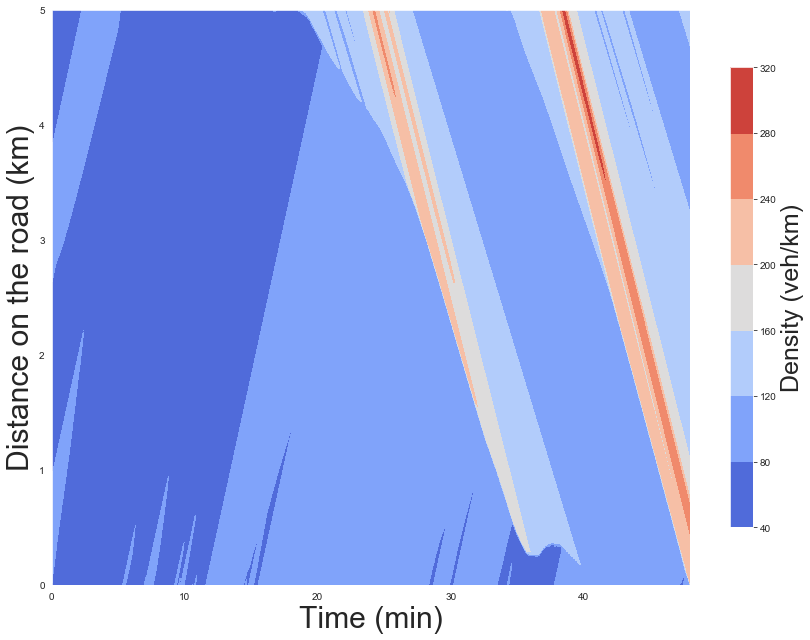

In [47]:
config_dict = {'my_analysis_dir': '2018/June2_2018-New_dataset',
                'run_num': 1,
                'data_array_dict':
                    {'flow': 'data_array_70108_flow_49t.csv',
                    'density': 'data_array_70108_density_49t.csv'},
               'ratio_times_BCs': 40,
                      }
LWR = LWR_Solver(config_dict=config_dict)


df_mean = mcmc_vis.concat_chains(params=['z', 'rho_j','u','w'], burnin=0).mean()
df_BCs = mcmc_vis.concat_chains(params=['BC_outlet', 'BC_inlet'], burnin=0)

FD = df_mean.to_dict()
# FD = deepcopy(FD_delCast_simulated)
FD['solver'] = 'lwr_del_Cast'
FD['w'] = 1/FD['w']

FD['BC_outlet'] = df_BCs['BC_outlet'].mean()
FD['BC_inlet'] = df_BCs['BC_inlet'].mean()


title_save = None
# title_save = "DelCastSim_TRUE_PARAMS-XT_density.png"


plot_LWR_xt(FD=FD, data_variable='density', config_dict=config_dict,
           out_times=np.linspace(0,40*LWR.final_time, 1200), 
            title_save=title_save)

In [ ]:
mcmc_vis.print_chain_info()
sample_alpha_val = 0.1
chain_list = [1,2,3,4]
chain_list = [1]

N_BCs = len(mcmc_vis.d_samples['MCMC_1'].iloc[0]['BC_outlet'])
color_list = ['r','b','g','m','y']

burnin = 0
step = 10
array_BCs = mcmc_vis.concat_chains(burnin=burnin, chains=chain_list, params=['BC_inlet', 'BC_outlet']).values
array_outlet = array_BCs[:, 1]
array_inlet = array_BCs[:, 0]


print("plotting {} BCs\n\n".format((len(array_outlet[::step]))))
plt.figure(figsize=(20,10))
# for elem in array_outlet[::step]:
#     plt.plot(np.linspace(0,60, N_BCs), elem, linewidth=1, alpha=sample_alpha_val, c='r')

for chain_num in chain_list:
    for elem in mcmc_vis.concat_chains(burnin=burnin, chains=[chain_num], params=['BC_outlet']).BC_outlet.values[::step]:
        plt.plot(np.linspace(0, 40, N_BCs), elem, linewidth=1, alpha=sample_alpha_val, 
                 c=color_list[chain_num-1])
        
# plt.plot(np.linspace(0,60, N_BCs), FD_delCast_simulated['BC_outlet'], c='black', label="true BCs")
# plt.plot(np.linspace(0, 60, N_BCs), mcmc.move.BC_prior_mean['BC_outlet'], c='blue', label="prior mean")

plt.xlabel("Time (min)", size=30)
plt.ylabel('Density (veh/km)', size=30)
# plt.title("Outlet BC samples", size=25)
# plt.legend(prop={'size': 20})
# plt.savefig("figures/delCast_DS1_FDBC_CorrPT-outlet_BC_samples.png")

print("plotting {} BCs\n\n".format((len(array_inlet[::step]))))
plt.figure(figsize=(20,10))
# for elem in array_inlet[::step]:
#     plt.plot(np.linspace(0,60, N_BCs), elem, linewidth=1, alpha=sample_alpha_val, c='r')

for chain_num in chain_list:
    for elem in mcmc_vis.concat_chains(burnin=burnin, chains=[chain_num], params=['BC_inlet']).BC_inlet.values[::step]:
        plt.plot(np.linspace(0, 40, N_BCs), elem, linewidth=1, alpha=sample_alpha_val, 
                 c=color_list[chain_num-1])

# plt.plot(np.linspace(0,60, N_BCs), FD_delCast_simulated['BC_inlet'], c='black', label="true BCs")
# plt.plot(np.linspace(0, 60, N_BCs), mcmc.move.BC_prior_mean['BC_inlet'], c='blue', label="prior mean")

plt.xlabel("Time (min)", size=30)
plt.ylabel('Density (veh/km)', size=30)

# plt.title("Inlet BC samples", size=25)
# plt.legend(prop={'size': 20})
# plt.savefig("figures/delCast_DS1_FDBC_CorrPT-inlet_BC_samples.png")

## BC R_hat values

In [ ]:

plt.rcParams.update({'font.size': 20})

In [ ]:
BC_type = 'BC_outlet'

t_list = np.linspace(0, 40, 50)
mcmc_vis.plot_BC_R_hat(BC_type=BC_type, t_list=t_list, burnin=0)
# plt.savefig("figures/delCast_sim_FDBC-outlet_Rhat.png")

In [ ]:
BC_type = 'BC_inlet'

t_list = np.linspace(0, 40, 50)
mcmc_vis.plot_BC_R_hat(BC_type=BC_type, t_list=t_list, burnin=0)
# plt.savefig("figures/delCast_sim_FDBC-inlet_Rhat.png")

## BC trace plots

In [ ]:
BC_type = 'BC_outlet'
chains = [1,2,3,4]
chains = [1]
burnin = 0
step = 1
cell_num_list = np.arange(0, N_BCs, 39)

mcmc_vis.print_chain_info()
mcmc_vis.BC_trace_plots(BC_type, cell_num_list, step=step, chains=chains, burnin=burnin)

In [ ]:
BC_type = 'BC_inlet'
chains = [1,2,3,4]
chains = [1]
burnin = 0
step = 1
cell_num_list = np.arange(0, N_BCs, 39)

mcmc_vis.print_chain_info()
mcmc_vis.BC_trace_plots(BC_type, cell_num_list, step=step, chains=chains, burnin=burnin)

In [ ]:
BC_type = 'BC_outlet'

N_BCs = len(mcmc_vis.d_samples['MCMC_1'].iloc[0].BC_outlet)
chains = [1,2,3,4,]
chains = [1]
burnin = 0
step = 1
cell_num_list = [0, 429, 1560,]
# cell_num_list = [0, 5, 10, 15]

mcmc_vis.BC_trace_plots(BC_type, cell_num_list, step=step, chains=chains, burnin=burnin,
                       figsize=(15,10))
# plt.savefig("figures/delCast_sim_FDBC-outlet_traceplot.png")



In [ ]:
BC_type = 'BC_inlet'

N_BCs = len(mcmc_vis.d_samples['MCMC_1'].iloc[0].BC_outlet)
chains = [1,2,3,4]
chains = [1]
burnin = 0
step = 1
cell_num_list = [156, 251, 1170]

mcmc_vis.BC_trace_plots(BC_type, cell_num_list, step=step, chains=chains, burnin=burnin,
                       figsize=(15,10))
# plt.savefig("figures/delCast_sim_FDBC-inlet_traceplot.png")
